In [269]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from IPython.display import display

import seaborn as sns
sns.set_style('darkgrid')

In [270]:
# Load the dataset. If in kaggle, it will silently fall over and use the alternative path.
try:
    ds = pd.read_csv("nhis_00002.csv")
except FileNotFoundError:
    ds = pd.read_csv("/kaggle/input/nhis-00002/nhis_00002.csv")
type(ds)

pandas.core.frame.DataFrame

In [271]:
ds_len = len(ds)
print(ds_len)
ds.head()

75101


,YEAR,SERIAL,STRATA,PSU,NHISHID,PERNUM,NHISPID,HHX,SAMPWEIGHT,LONGWEIGHT,...,HEARTATTEV,LEARNDEV,RETEV,DIABETICAGE,SPEDEV,AEFFORT,ASAD,AWORTHLESS,SATISFIED,SATSCORE
0,2020,1,150,25,0002020H000002,1,0002020H00000210,H000002,5946.002,17605.50,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN
1,2020,2,111,10,0002020H000003,1,0002020H00000310,H000003,6288.726,0.00,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN
2,2020,3,133,3,0002020H000004,1,0002020H00000410,H000004,6083.271,0.00,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN
3,2020,4,139,45,0002020H000007,1,0002020H00000710,H000007,11306.962,0.00,...,1,0,0,53,0,NaN,NaN,NaN,NaN,NaN
4,2020,5,130,21,0002020H000009,1,0002020H00000910,H000009,6471.818,19317.18,...,1,0,0,96,0,NaN,NaN,NaN,NaN,NaN


## Race Demographics

This dataset consists of 75,101 rows. The pie chart below displays the distribution of race demographics in the dataset.

For comparison, here are the Census Bureau estimates for the US population in 2020:

- White alone, not Hispanic or Latino: 60.1%
- Black or African American alone: 13.4%
- American Indian and Alaska Native alone: 1.0%
- Asian alone: 6.0%
- Native Hawaiian and Other Pacific Islander alone: 0.2%
- Some other race alone: 2.7%
- Two or more races: 7.8%
- Hispanic or Latino (of any race): 18.7%

Source: https://www.census.gov/quickfacts/fact/table/US/PST045222

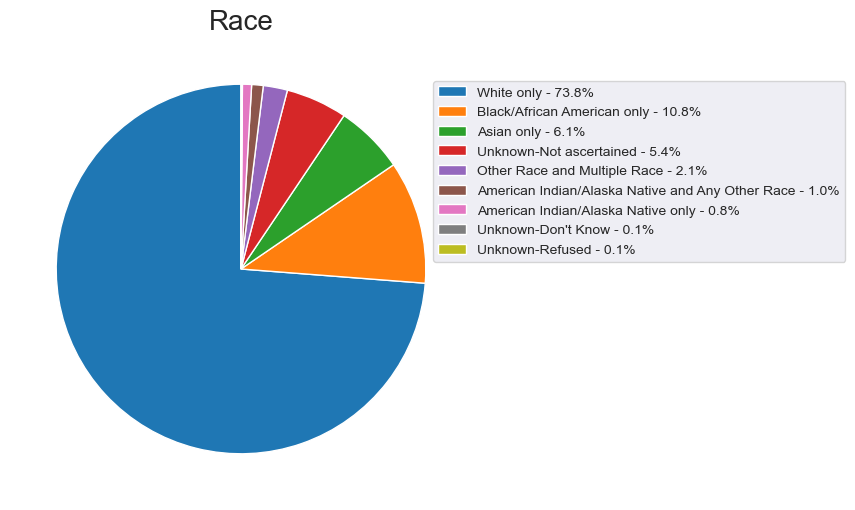

In [272]:
# Create a dictionary to map the race code to the actual race label
code_to_race = {
    100: 'White only',
    200: 'Black/African American only',
    300: 'American Indian/Alaska Native only',
    400: 'Asian only',
    510: 'Other Race and Multiple Race',
    542: 'American Indian/Alaska Native and Any Other Race',
    997: 'Unknown-Refused',
    998: 'Unknown-Not ascertained',
    999: "Unknown-Don't Know"
}

# Count the number of responses for each race code in the dataset
counts = ds['RACENEW'].value_counts()

# Create a list of the actual race labels using the dictionary
labels = [code_to_race[code] for code in counts.index]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the pie chart
ax.pie(counts, startangle=90)
ax.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10,
          labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts)])
ax.set_title("Race", size=20)
plt.show()

## Gender Demographics

The chart below shows the gender distribution in the sample compared to the US population based on US census data.

As of 2020, the US population is estimated to be 50.8% female and 49.2% male

Total excluded rows: 10


Text(0.5, 1.0, 'Gender')

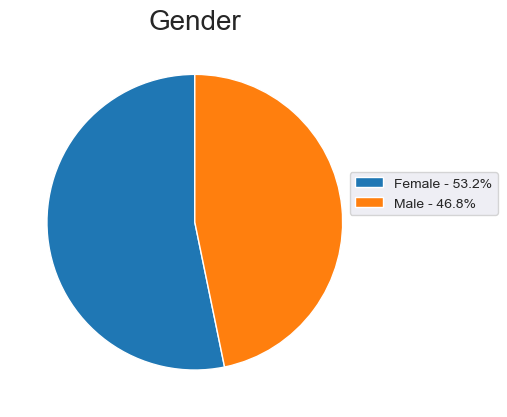

In [273]:
code_to_gender = {
    1: 'Male',
    2: 'Female',
    7: 'Unknown-refused',
    8: 'Unknown-not ascertained',
    9: "Unknown-don't know"
}

# Codes 7, 8 and 9 represents a total of 10 values, and is too miniscule to carry a percentage.
filtered_ds = ds.loc[ds['SEX'].isin([1, 2])]
counts = filtered_ds['SEX'].value_counts()
total_counts = counts.sum()
print (f"Total excluded rows: {ds_len - total_counts}")
labels = [code_to_gender[code] for code in counts.index]
plt.pie(counts, startangle=90, autopct='')
plt.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10, 
           labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts)])
plt.title("Gender", size=20)


### Family Income

24.0    12027
11.0     9136
22.0     6699
23.0     4855
12.0     4641
Name: INCFAM07ON, dtype: int64


Text(0.5, 1.0, 'Family Income')

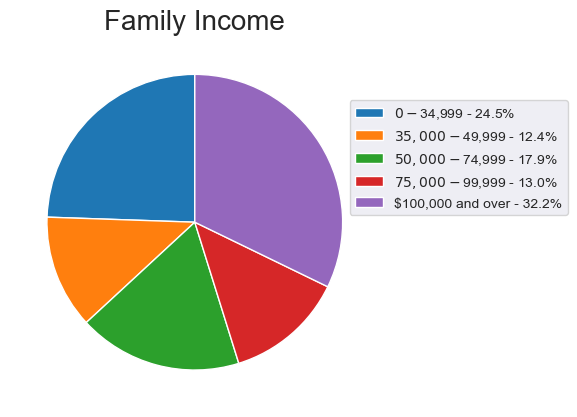

In [274]:
# Define a dictionary that maps income codes to income ranges
code_to_income = {
    11: '$0 - $34,999',
    12: '$35,000 - $49,999',
    22: '$50,000 - $74,999',
    23: '$75,000 - $99,999',
    24: '$100,000 and over'
}

# Get the counts for each income code in the dataset
counts = ds['INCFAM07ON'].value_counts()
print(counts)

# Get the labels for each income code
labels = [code_to_income[code] for code in counts.index]

# Sort the counts and labels in order of the income ranges
counts, labels = zip(*sorted(zip(counts, labels), key=lambda x: list(code_to_income.values()).index(x[1])))

# Create the pie chart
plt.pie(counts, startangle=90, autopct='')
plt.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10,
           labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts) if c != 0])
plt.title("Family Income", size=20)


## Defining protected features
HEALTH
1                   Excellent
2                   Very Good
3                   Good
4                   Fair
5                   Poor
7                   Unknown-refused
8                   Unknown-not ascertained
9                   Unknown-don't know

2    24149
1    23239
3    18497
4     7074
5     2105
7       21
9       16
Name: HEALTH, dtype: int64


Text(0.5, 1.0, 'Health')

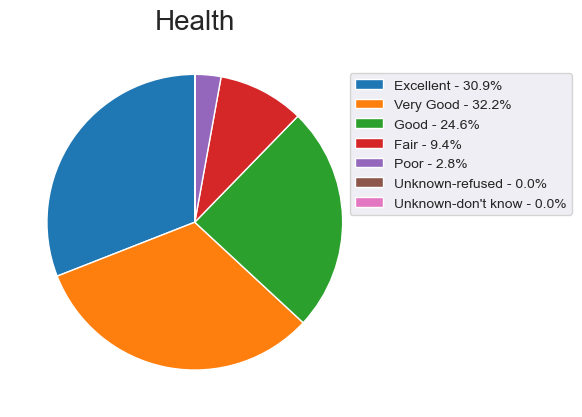

In [275]:
# Define a dictionary that maps income codes to income ranges
code_to_health = {
    1: 'Excellent',
    2: 'Very Good',
    3: 'Good',
    4: 'Fair',
    5: 'Poor',
    7: 'Unknown-refused',
    8: 'Unknown-not ascertained',
    9: "Unknown-don't know"
}

# Get the counts for each income code in the dataset
counts = ds['HEALTH'].value_counts()
print(counts)

# Get the labels for each income code
labels = [code_to_health[code] for code in counts.index]

# Sort the counts and labels in order of the income ranges
counts, labels = zip(*sorted(zip(counts, labels), key=lambda x: list(code_to_health.values()).index(x[1])))

# Create the pie chart
plt.pie(counts, startangle=90, autopct='')
plt.legend(loc="lower left", bbox_to_anchor=(0.9, 0.5), ncol=1, fontsize=10,
           labels=['{} - {:.1f}%'.format(l, c/sum(counts)*100) for l, c in zip(labels, counts) if c != 0])
plt.title("Health", size=20)

In [276]:
# Create a new dataframe with only the necessary columns
ds_fair = ds[['RACENEW', 'INCFAM07ON', 'SEX']]

# Rename the columns for clarity
ds_fair = ds_fair.rename(columns={'RACENEW': 'race', 'INCFAM07ON': 'income', 'SEX': 'sex'})

# Define privileged race and income. 100 is white, 24 is 100k+
privileged_race = 100
privileged_income = [24]
privileged_sex = [1]

# Create the privileged variables
ds_fair['priv_race'] = ds_fair['race'].apply(lambda x: 1 if x == privileged_race else 0)
ds_fair['priv_income'] = ds_fair['income'].apply(lambda x: 1 if x in privileged_income else 0)
ds_fair['priv_sex'] = ds_fair['sex'].apply(lambda x: 1 if x in privileged_sex else 0)

ds_fair['y'] = [1 if y == 1 else 0 for y in ds['HEALTH']]
display(ds_fair[:15])

,race,income,sex,priv_race,priv_income,priv_sex,y
0,100,11.0,2,1,0,0,1
1,100,24.0,1,1,1,1,0
2,100,24.0,2,1,1,0,0
3,100,22.0,1,1,0,1,0
4,100,23.0,2,1,0,0,0
5,100,24.0,1,1,1,1,0
6,100,23.0,1,1,0,1,1
7,542,24.0,2,0,1,0,0
8,100,12.0,2,1,0,0,1
9,200,11.0,2,0,0,0,0


## Prevalence of protected features

In [277]:
# Calculate prevalence
prev = ds_fair['y'].mean()
#prev_race = ds_fair.groupby('priv_race')['y'].mean()
prev_income = ds_fair.groupby('priv_income')['y'].mean()
prev_sex = ds_fair.groupby('priv_sex')['y'].mean()
prev_comb = ds_fair.groupby(['priv_income','priv_sex'])['y'].mean()

print(prev)
#print(prev_race)
print(prev_income)
print(prev_sex)
print(prev_comb)

0.30943662534453603
priv_income
0    0.290579
1    0.408331
Name: y, dtype: float64
priv_sex
0    0.298282
1    0.322134
Name: y, dtype: float64
priv_income  priv_sex
0            0           0.277514
             1           0.306001
1            0           0.419853
             1           0.397481
Name: y, dtype: float64


### Proxy Variable

In [278]:
y = [1 if y == 1 else 0 for y in ds['HEALTH']]

#Model features
X = ds[['SEXORIEN','EDUC', 'CITIZEN', 'OWNERSHIP', 'HINOTCOVE']]
#X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']]
#X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']]

edu_groups = {
    000: -1,  # Unknown/NIU
    100: 0,   # Grade 12 or less, no high school diploma or equivalent
    102: 0,   # Never attended/kindergarten only
    103: 0,   # Grade 1-11
    113: 0,   # Grade 9
    114: 0,   # Grade 10
    115: 0,   # Grade 11
    116: 0,   # 12th grade, no diploma
    200: 1,   # High school diploma or GED
    201: 1,   # High school graduate
    202: 1,   # GED or equivalent
    300: 2,   # Some college, no 4yr degree
    301: 2,   # Some college, no degree
    302: 2,   # AA degree: technical/vocational/occupational
    303: 2,   # AA degree: academic program
    400: 3,   # Bachelor's degree (BA,AB,BS,BBA)
    500: 4,   # Master's, Professional, or Doctoral Degree
    501: 4,   # Master's degree (MA,MS,Med,MBA)
    502: 4,   # Professional (MD,DDS,DVM,JD)
    503: 4,   # Doctoral degree (PhD, EdD)
    504: 4,   # Other degree
    505: 4,   # Professional School or Doctoral degree, topcoded (MD, DDS, DVM, JD, PhD, EdD)
    996: -1,  # No degree, years of education unknown
    997: -1,  # Unknown--refused
    998: -1,  # Unknown--not ascertained
    999: -1   # Unknown--don't know
}

orien_groups = {
    0: -1,    # NIU
    1: 0,     # Lesbian or gay
    2: 1,     # Straight
    3: 0,     # Bisexual
    4: 0,     # Something else
    5: 0,     # Don't know
    7: -1,    # Refused
    8: -1,    # Not ascertained
}

citizen_groups = {
    1: 0,  # No, not U.S. citizen
    2: 1,  # Yes, U.S. citizen
    7: -1,  # Unknown--refused
    8: -1,  # Unknown--not ascertained
    9: -1,  # Unknown--don't know
}

ownership_group = {00: -1,
                  10: 1,
                  11: 1,
                  12: 1,
                  20: 0,
                  30: 0,
                  40: 0,
                  97: -1,
                  98: -1,
                  99: -1}

insurance_group = {
    0: -1,  # NIU
    1: 1,   # Has coverage
    2: 0,   # Has no coverage
    7: -1,  # Unknown-refused
    8: -1,  # Unknown-not ascertained
    9: -1,  # Unknown-don't know
}


X['EDUC'] = [edu_groups[x] for x in ds['EDUC']]
X['SEXORIEN'] = [orien_groups[x] for x in ds['SEXORIEN']]
X['CITIZEN'] = [citizen_groups[x] for x in ds['CITIZEN']]
X['OWNERSHIP'] = [ownership_group[x] for x in ds['OWNERSHIP']]
X['HINOTCOVE'] = [insurance_group[x] for x in ds['HINOTCOVE']]

X.head()

,SEXORIEN,EDUC,CITIZEN,OWNERSHIP,HINOTCOVE
0,1,4,1,1,1
1,1,4,1,1,1
2,1,4,1,1,1
3,1,0,-1,-1,1
4,1,3,1,-1,0
